In [9]:
import numpy as np
import os
from PIL import Image
import h5py 
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [15]:
def cost(y,x):
    return (np.linalg.norm(np.absolute(y)- np.absolute(x) ))/(np.linalg.norm(x))

def posterior(y, x, meth,alpha, gamma=1):  
    if alpha < 0 or alpha > 1:
        return
    m,n = y.shape
    likelihood = np.sum(np.square(np.absolute(y-x)))
    up = np.absolute(x-np.roll(x, [1,0], [0,1]))
    down = np.absolute(x-np.roll(x, [m-1,0], [0,1]))
    left = np.absolute(x-np.roll(x, [0,1], [0,1]))
    right = np.absolute(x-np.roll(x, [0,n-1], [0,1]))     
    
    if meth=="quadratic":
        prior = np.sum(np.square(up) + np.square(down) + np.square(left) + np.square(right))
    elif meth=="huber":
        prior_up = np.multiply(np.less_equal(up,gamma) , up**2/2) + np.multiply(np.greater(up,gamma) , (gamma*up - gamma**2/2)) 
        prior_down = np.multiply(np.less_equal(down,gamma) , down**2/2) + np.multiply(np.greater(down,gamma) , (gamma*down - gamma**2/2)) 
        prior_left = np.multiply(np.less_equal(left,gamma) , left**2/2) + np.multiply(np.greater(left,gamma) , (gamma*left - gamma**2/2)) 
        prior_right = np.multiply(np.less_equal(right,gamma) , right**2/2) + np.multiply(np.greater(right,gamma) , (gamma*right - gamma**2/2)) 
        prior = np.sum(prior_up + prior_down + prior_left + prior_right)
    elif meth=="log":
        prior_up = gamma*up - gamma**2*np.log(1+up/gamma)
        prior_down = gamma*down - gamma**2*np.log(1+down/gamma)
        prior_left = gamma*left - gamma**2*np.log(1+left/gamma)
        prior_right =gamma*right - gamma**2*np.log(1+right/gamma)     
        prior = np.sum(prior_up + prior_down + prior_left + prior_right)
        
    return (1-alpha)*likelihood + alpha*prior

#based on dynamic step size
def gradiant(y,x,meth, alpha, gamma=1):
    if alpha < 0 or alpha > 1:
        return
    m,n = y.shape    
    likelihood = 2*(y-x)
    up = x-np.roll(x, [1,0], [0,1])
    down = x-np.roll(x, [m-1,0], [0,1])
    left = x-np.roll(x, [0,1], [0,1])
    right = x-np.roll(x, [0,n-1], [0,1])    
    
    if meth=="quadratic":
        prior = 2*(up+down+left+right)
    elif meth=="huber":
        prior_up = np.multiply(np.less_equal(np.absolute(up),gamma) , up) + np.multiply(np.greater(np.absolute(up),gamma) , (gamma*up/np.abs(up) ) )
        prior_down =  np.multiply(np.less_equal(np.absolute(down),gamma) , down) + np.multiply(np.greater(np.absolute(down),gamma) , (gamma*down/np.abs(down) ) )
        prior_left =  np.multiply(np.less_equal(np.absolute(left),gamma) , left) + np.multiply(np.greater(np.absolute(left),gamma) , (gamma*left/np.abs(left) ) )
        prior_right = np.multiply(np.less_equal(np.absolute(right),gamma) , right) + np.multiply(np.greater(np.absolute(right),gamma) , (gamma*right/np.abs(right) ) )
        prior = prior_up + prior_down + prior_left + prior_right
    elif meth=="log":
        prior_up = np.multiply(gamma*up , np.reciprocal(gamma + np.absolute(up)))
        prior_down = np.multiply(gamma*down , np.reciprocal(gamma + np.absolute(down)))
        prior_left = np.multiply(gamma*left , np.reciprocal(gamma + np.absolute(left)))
        prior_right =np.multiply (gamma*right , np.reciprocal(gamma + np.absolute(right)) )    
        prior = prior_up + prior_down + prior_left + prior_right
        
    return (1-alpha)*likelihood + alpha*prior    

def routine(imgNoisy, alpha, gamma, step, thresh, meth):
    old_model = np.copy(imgNoisy)
    old_posterior = posterior(imgNoisy, old_model,meth, alpha)
    posterior_val = []
    posterior_val.append(posterior)    
    if meth=="huber" or meth=="log":
        for i in range(1000):
            gradiant_img = gradiant(imgNoisy,old_model,meth, alpha,gamma)
            new_model = old_model - step*gradiant_img
            new_posterior = posterior(imgNoisy, new_model,meth, alpha,gamma)   
        
            if new_posterior < old_posterior:
                step  = 1.1*step
                old_model = new_model
                old_posterior = new_posterior
        
            else:
                step = 0.5*step
            posterior_val.append(old_posterior)

    else:
        while step > thresh:    
            gradiant_img = gradiant(imgNoisy,old_model,meth, alpha)
            new_model = old_model - step*gradiant_img
            new_posterior = posterior(imgNoisy, new_model,meth, alpha)   
        
            if new_posterior < old_posterior:
                step  = 1.1*step
                old_model = new_model
                old_posterior = new_posterior
        
            else:
                step = 0.5*step
            posterior_val.append(old_posterior)   
                      
    return posterior_val, new_model

In [6]:
file_name = "../input/MR_data_noisy001.png"
noisy_mri = Image.open(file_name)
noisy_mri = np.asarray(noisy_mri)

In [7]:
threshold = 1e-7
step = 1

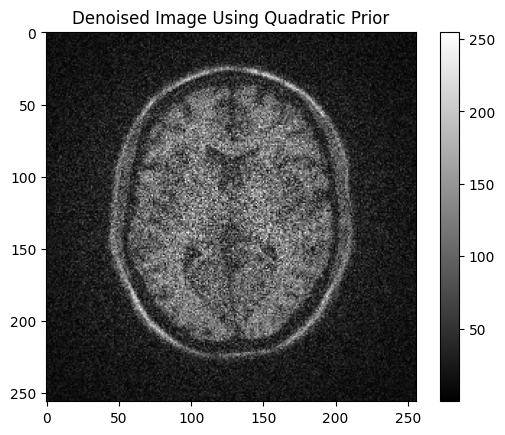

In [16]:
# Denoising Using Quadratic Prior
post_quad, denoised_model_quad = routine(noisy_mri, 0.125, 1, step, threshold, "quadratic")
# post_quad, denoised_model_quad = routine(imageNoisy, 0.125, 1, step, threshold, "quadratic")
post_quad = post_quad[1:]
plt.figure()
plt.imshow(np.absolute(denoised_model_quad),cmap='gray')
plt.title('Denoised Image Using Quadratic Prior')

plt.colorbar()

C:\Users\HP\AppData\Local\Temp\ipykernel_18012\1085164990.py:45: RuntimeWarning: invalid value encountered in divide
  prior_up = np.multiply(np.less_equal(np.absolute(up),gamma) , up) + np.multiply(np.greater(np.absolute(up),gamma) , (gamma*up/np.abs(up) ) )
C:\Users\HP\AppData\Local\Temp\ipykernel_18012\1085164990.py:46: RuntimeWarning: invalid value encountered in divide
  prior_down =  np.multiply(np.less_equal(np.absolute(down),gamma) , down) + np.multiply(np.greater(np.absolute(down),gamma) , (gamma*down/np.abs(down) ) )
C:\Users\HP\AppData\Local\Temp\ipykernel_18012\1085164990.py:47: RuntimeWarning: invalid value encountered in divide
  prior_left =  np.multiply(np.less_equal(np.absolute(left),gamma) , left) + np.multiply(np.greater(np.absolute(left),gamma) , (gamma*left/np.abs(left) ) )
C:\Users\HP\AppData\Local\Temp\ipykernel_18012\1085164990.py:48: RuntimeWarning: invalid value encountered in divide
  prior_right = np.multiply(np.less_equal(np.absolute(right),gamma) , right) 

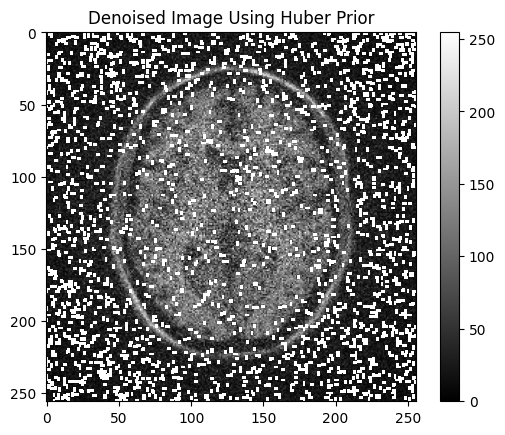

In [17]:
#Denoising Using Huber Prior
post_huber, denoised_model_huber = routine(noisy_mri, 0.4, 0.3, step, threshold, "huber")
post_huber=post_huber[1:]
plt.figure()
plt.imshow(np.absolute(denoised_model_huber),cmap='gray')
plt.title('Denoised Image Using Huber Prior')
plt.colorbar()

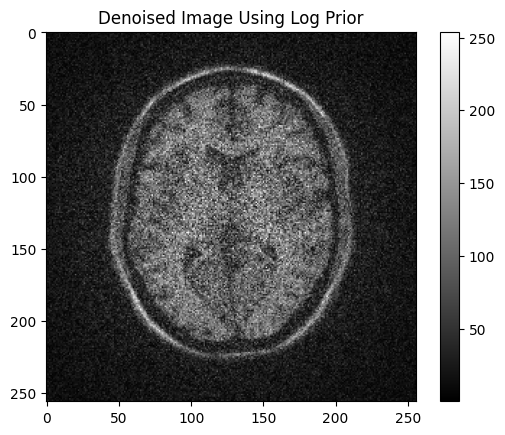

In [18]:
#Denoising Using Log Prior
post_log, denoised_model_log = routine(noisy_mri, 0.4, 0.6, step, threshold, "log")
post_log=post_log[1:]
plt.figure()
plt.imshow(np.absolute(denoised_model_log),cmap='gray')
plt.title('Denoised Image Using Log Prior')
plt.colorbar()

Text(0.5, 1.0, 'Noisy Image')

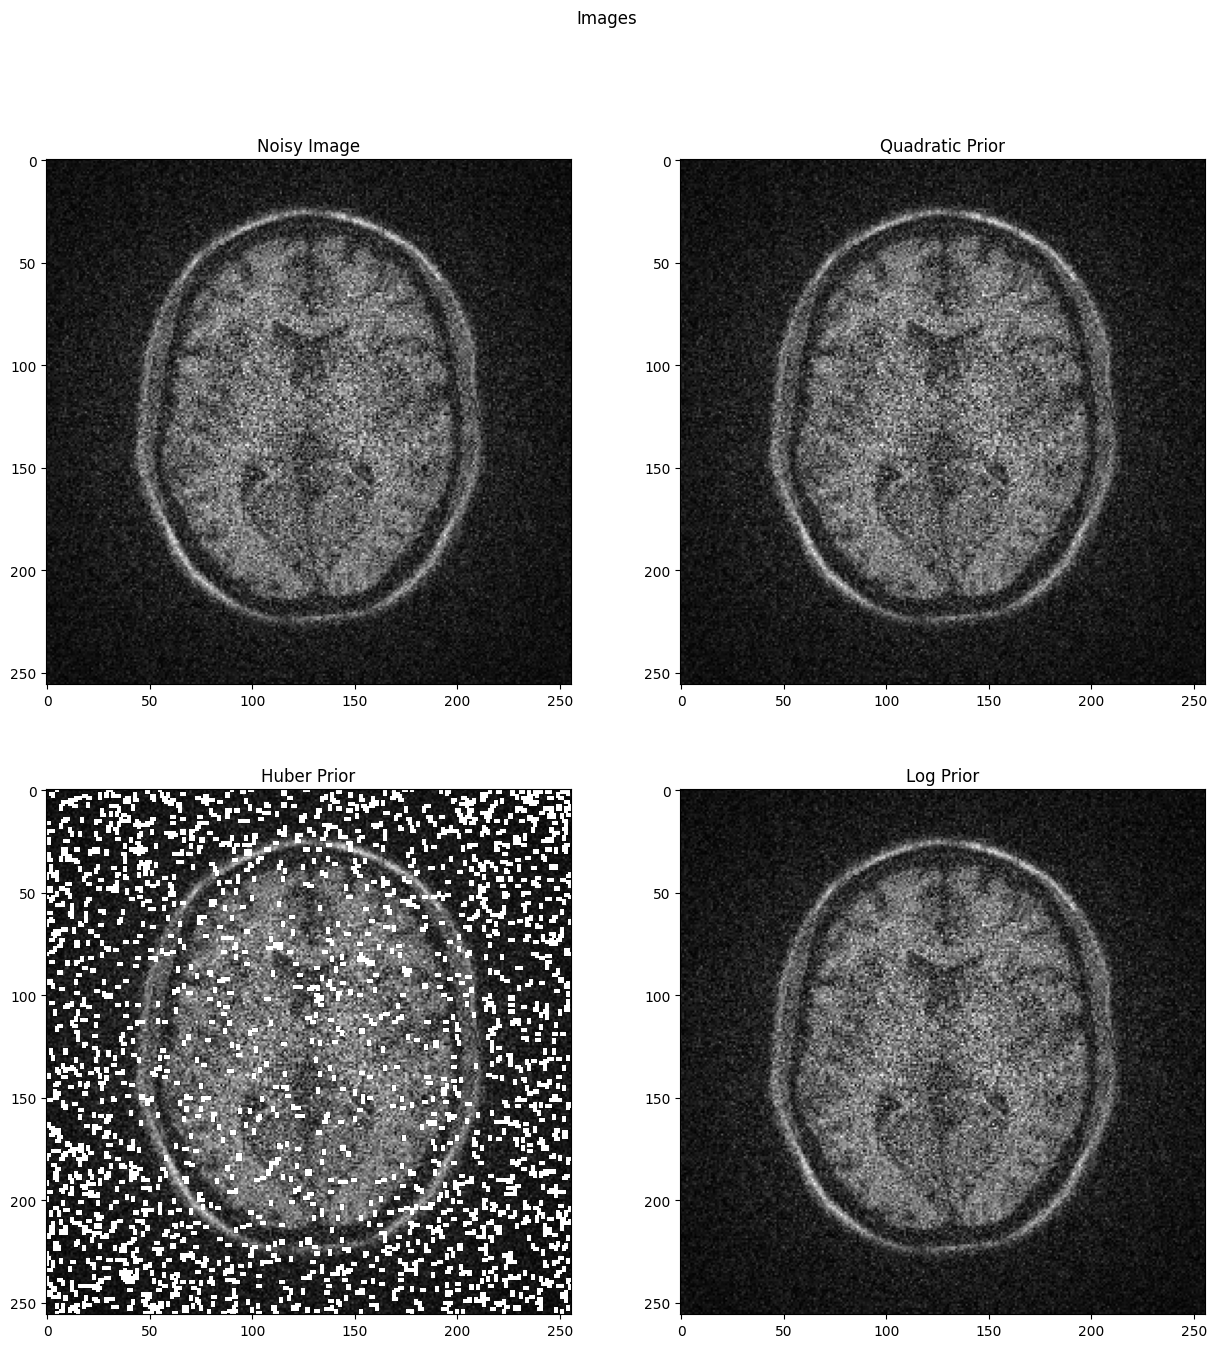

In [19]:
#Subplot
f, (((ax1, ax2), (ax3, ax4))) = plt.subplots(2, 2, figsize=(15,15))
plt.suptitle('Images')


ax2.imshow(np.absolute(denoised_model_quad),cmap='gray')
ax2.set_title('Quadratic Prior')

ax3.imshow(np.absolute(denoised_model_huber),cmap='gray')
ax3.set_title('Huber Prior')


ax4.imshow(np.absolute(denoised_model_log),cmap='gray')
ax4.set_title('Log Prior')

ax1.imshow(np.absolute(noisy_mri),cmap='gray')
ax1.set_title('Noisy Image')